In [1]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text
from dotenv import load_dotenv


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    data_dir: Path = project_dir / "data"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"


config = Config()
sys.path.append(str(config.project_dir.resolve()))
load_dotenv()

CPU times: user 331 ms, sys: 108 ms, total: 439 ms
Wall time: 784 ms


True

In [2]:
df_orders = pd.read_csv(config.interim_dir / "olist_orders_customer_merged.csv")
df_item_products = pd.read_csv(
    config.interim_dir / "olist_item_product_seller_merged.csv"
)

In [3]:
df_orders_item_products_merged = pd.merge(
    df_orders, df_item_products, on="order_id", how="left"
)
assert (
    df_orders_item_products_merged["order_id"].nunique()
    == df_orders["order_id"].nunique()
)

df_orders_item_products_merged_for_categorize_items = df_orders_item_products_merged[
    [
        "order_id",
        "product_id",
        "product_category_name_english",
        "order_purchase_month",
        "price",
    ]
].drop_duplicates()

In [4]:
df_orders_item_products_merged.shape

(113425, 44)

## 対象期間のうち，伸び悩んでいる製品カテゴリを特定したい

In [4]:
df_orders_item_products_merged_for_categorize_items.groupby(
    ["order_purchase_month", "product_category_name_english"]
).size().reset_index()

,order_purchase_month,product_category_name_english,0
0,2016-09,furniture_decor,2
1,2016-09,health_beauty,1
2,2016-09,telephony,1
3,2016-10,air_conditioning,5
4,2016-10,audio,2
...,...,...,...
1248,2018-08,stationery,162
1249,2018-08,telephony,250
1250,2018-08,toys,159
1251,2018-08,watches_gifts,411


In [5]:
df_orders_item_products_merged_for_categorize_items.groupby(["order_purchase_month"])[
    "product_category_name_english"
].size()

order_purchase_month
2016-09       5
2016-10     343
2016-12       1
2017-01     835
2017-02    1840
2017-03    2772
2017-04    2479
2017-05    3843
2017-06    3358
2017-07    4191
2017-08    4502
2017-09    4434
2017-10    4835
2017-11    7875
2017-12    5872
2018-01    7565
2018-02    6907
2018-03    7440
2018-04    7236
2018-05    7137
2018-06    6411
2018-07    6511
2018-08    6788
2018-09      16
2018-10       4
Name: product_category_name_english, dtype: int64

In [6]:
start_date, end_date = (
    df_orders_item_products_merged_for_categorize_items["order_purchase_month"].min(),
    df_orders_item_products_merged_for_categorize_items["order_purchase_month"].max(),
)
all_months = df_orders_item_products_merged.query(
    "order_purchase_month >= @start_date & order_purchase_month <= @end_date"
)["order_purchase_month"].unique()

all_categories = df_orders_item_products_merged_for_categorize_items[
    "product_category_name_english"
].unique()

# 全ての月とカテゴリーの組み合わせを作成
month_category_combinations = pd.MultiIndex.from_product(
    [all_months, all_categories],
    names=["order_purchase_month", "product_category_name_english"],
)

monthly_category_counts_by_n_sales = (
    df_orders_item_products_merged_for_categorize_items.groupby(
        ["order_purchase_month", "product_category_name_english"]
    )["order_id"]
    .nunique()
    .reindex(month_category_combinations, fill_value=0)
    .reset_index(name="sum")
    .sort_values("order_purchase_month")
)
monthly_category_counts_by_revs = (
    df_orders_item_products_merged_for_categorize_items.groupby(
        ["order_purchase_month", "product_category_name_english"]
    )["price"]
    .sum()
    .reindex(month_category_combinations, fill_value=0)
    .reset_index(name="sum")
    .sort_values("order_purchase_month")
)


In [7]:
df_orders_item_products_merged.query("order_purchase_month == '2016-12'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month,order_purchase_date,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
45314,bd50a7fe9fd97ea4b7663031a319e150,0975c3cf2e418ebfa5d1191a2dffd59d,delivered,2016-12-23 23:16:47,2016-12-23 23:31:37,2016-12-27 06:14:27,2016-12-28 15:54:44,2017-01-19,2016-12,2016-12-23,...,1710.0,1.0,200.0,16.0,2.0,11.0,fashion_bags_accessories,81130.0,curitiba,PR


In [8]:
# 差分を計算
ff_diff_df = pd.DataFrame(
    {
        "2017-02": monthly_category_counts_by_revs.query(
            "order_purchase_month == '2017-02'"
        ).set_index("product_category_name_english")["sum"],
        "2017-10": monthly_category_counts_by_revs.query(
            "order_purchase_month == '2017-10'"
        ).set_index("product_category_name_english")["sum"],
    }
)
# 差分と変化率を計算
ff_diff_df["difference"] = ff_diff_df["2017-10"] - ff_diff_df["2017-02"]
ff_diff_df["change_rate"] = (
    (ff_diff_df["2017-10"] - ff_diff_df["2017-02"]) / ff_diff_df["2017-02"] * 100
).round(2)
ff_diff_df = ff_diff_df.sort_values("difference", ascending=False)
# 差分を計算
sf_diff_df = pd.DataFrame(
    {
        "2017-12": monthly_category_counts_by_revs.query(
            "order_purchase_month == '2017-12'"
        ).set_index("product_category_name_english")["sum"],
        "2018-08": monthly_category_counts_by_revs.query(
            "order_purchase_month == '2018-08'"
        ).set_index("product_category_name_english")["sum"],
    }
)
# 差分と変化率を計算
sf_diff_df["difference"] = sf_diff_df["2018-08"] - sf_diff_df["2017-12"]
sf_diff_df["change_rate"] = (
    (sf_diff_df["2018-08"] - sf_diff_df["2017-12"]) / sf_diff_df["2017-12"] * 100
).round(2)
sf_diff_df = sf_diff_df.sort_values("difference", ascending=False)

In [9]:
diff_by_category_name_df = pd.merge(
    ff_diff_df,
    sf_diff_df,
    left_index=True,
    right_index=True,
    suffixes=("_first", "_second"),
)
diff_by_category_name_df = pd.merge(
    diff_by_category_name_df,
    monthly_category_counts_by_revs.groupby("product_category_name_english")[
        "sum"
    ].sum(),
    left_index=True,
    right_index=True,
    how="left",
).sort_values("sum", ascending=False)

In [18]:
import numpy as np

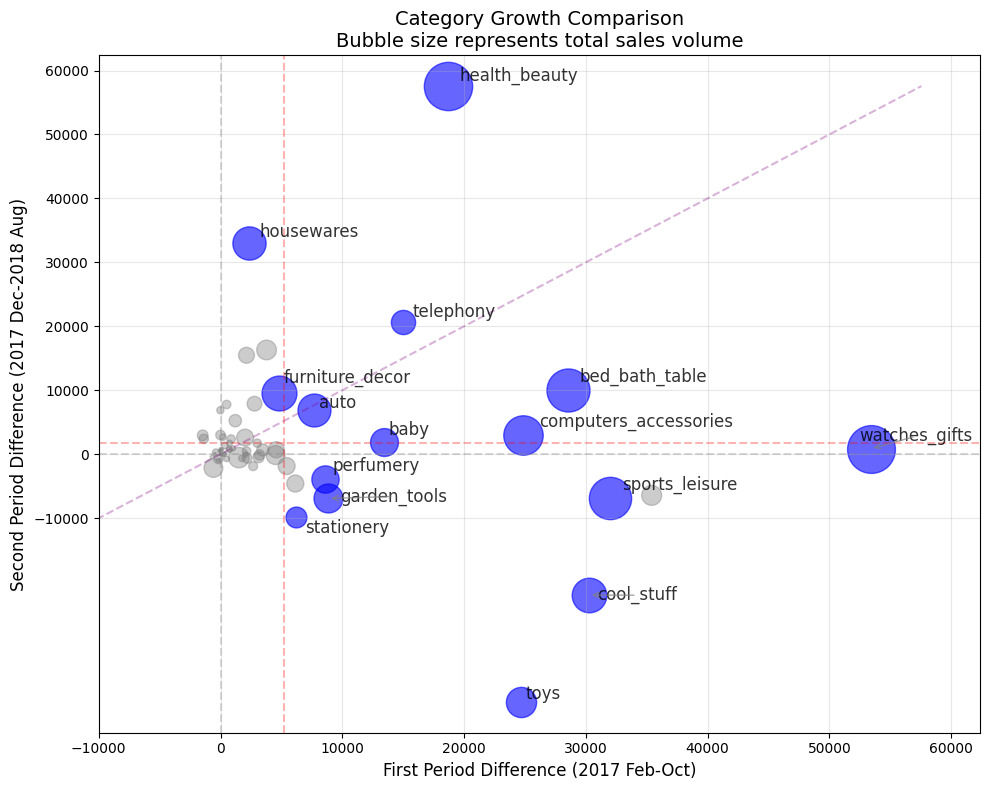

In [29]:
# プロットの作成
fig, ax = plt.subplots(figsize=(10, 8))

# 上位15カテゴリーを抽出
top_15_categories = diff_by_category_name_df.nlargest(15, "sum").index
other_categories = diff_by_category_name_df.loc[
    ~diff_by_category_name_df.index.isin(top_15_categories)
].index

# その他のカテゴリーを薄い色でプロット（ラベルなし）
ax.scatter(
    diff_by_category_name_df.loc[other_categories, "difference_first"],
    diff_by_category_name_df.loc[other_categories, "difference_second"],
    s=diff_by_category_name_df.loc[other_categories, "sum"] / 1000,
    alpha=0.4,
    c="gray",
    label="Others",
)

# テキストオブジェクトのリストを作成
texts = []

# 上位20カテゴリーをプロット
for category in top_15_categories:
    scatter = ax.scatter(
        diff_by_category_name_df.loc[category, "difference_first"],
        diff_by_category_name_df.loc[category, "difference_second"],
        s=diff_by_category_name_df.loc[category, "sum"] / 1000,
        alpha=0.6,
        c="blue",
        label=category,
    )

    # テキストオブジェクトを作成してリストに追加
    text = ax.text(
        diff_by_category_name_df.loc[category, "difference_first"],
        diff_by_category_name_df.loc[category, "difference_second"],
        category,
        fontsize=12,
        alpha=0.8,
    )
    texts.append(text)
# y=xの直線を追加（データの範囲に合わせて）
min_val = min(
    diff_by_category_name_df["difference_first"].min(),
    diff_by_category_name_df["difference_second"].min(),
)
max_val = max(
    diff_by_category_name_df["difference_first"].max(),
    diff_by_category_name_df["difference_second"].max(),
)
ax.plot(
    [min_val, max_val], [min_val, max_val], "--", color="purple", alpha=0.3, label="y=x"
)
# 原点を通る縦線と横線を追加
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.3)
ax.axvline(x=0, color="gray", linestyle="--", alpha=0.3)
ax.axhline(
    y=diff_by_category_name_df["difference_second"].mean(),
    color="red",
    linestyle="--",
    alpha=0.3,
)
ax.axvline(
    x=diff_by_category_name_df["difference_first"].mean(),
    color="red",
    linestyle="--",
    alpha=0.3,
)

# ラベルとタイトルの設定
ax.set_xlabel("First Period Difference (2017 Feb-Oct)", fontsize=12)
ax.set_ylabel("Second Period Difference (2017 Dec-2018 Aug)", fontsize=12)
ax.set_title(
    "Category Growth Comparison\nBubble size represents total sales volume", fontsize=14
)
ax.set_xlim(xmin=-5000)
# グリッドの追加
# X軸の範囲を設定
ax.set_xlim(xmin=-5000)

# グリッド線を20000単位で設定
major_ticks = np.arange(-10000, max_val + 10000, 10000)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)

# グリッドの追加
ax.grid(True, alpha=0.3)
# ax.set_aspect(2.0)
# テキストの位置を自動調整
adjust_text(
    texts,
    arrowprops=dict(arrowstyle="->", color="gray", alpha=0.7),
    expand_points=(1.5, 1.5),
    force_points=(0.1, 0.1),
)

# レイアウトの調整
plt.tight_layout()
plt.show()

In [11]:
from src.visualizer.vis_functions import plot_category_sales_trend

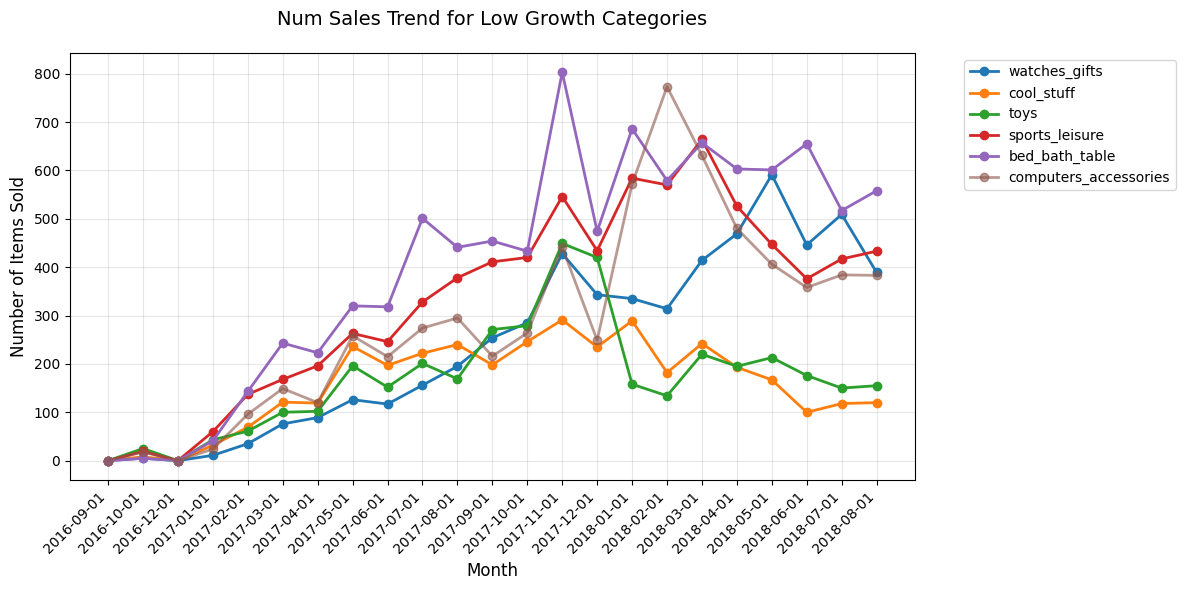

In [31]:
low_growth_categories = [
    "watches_gifts",
    "cool_stuff",
    "toys",
    "sports_leisure",
    "bed_bath_table",
    "computers_accessories",
]

plot_category_sales_trend(
    categories=low_growth_categories,
    df_merged=df_orders_item_products_merged,
    start_date="2016-09",
    end_date="2018-08",
    title="Num Sales Trend for Low Growth Categories",
    agg_type="revs",
)

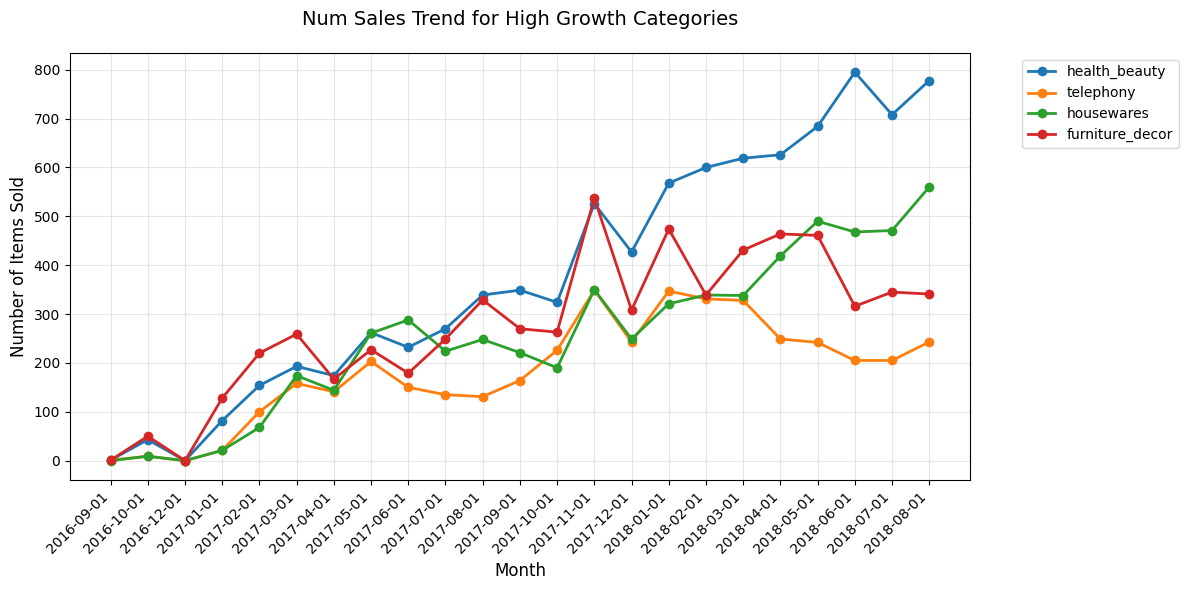

In [32]:
high_growth_categories = ["health_beauty", "telephony", "housewares", "furniture_decor"]

plot_category_sales_trend(
    categories=high_growth_categories,
    df_merged=df_orders_item_products_merged,
    start_date="2016-09",
    end_date="2018-08",
    title="Num Sales Trend for High Growth Categories",
    agg_type="revs",
)

### わかったこと
- 売り上げ成長が鈍化したカテゴリ-
    1. "watches_gifts"
    2. "cool_stuff"
    3. "toys"
    4. "sports_leisure"
    5. "bed_bath_table"
    6. "computers_accessories"
- 売り上げ成長が急増したカテゴリー
    1. health_beauty
    2. telephony
    3. (housewares)
    4. (furniture_decor)

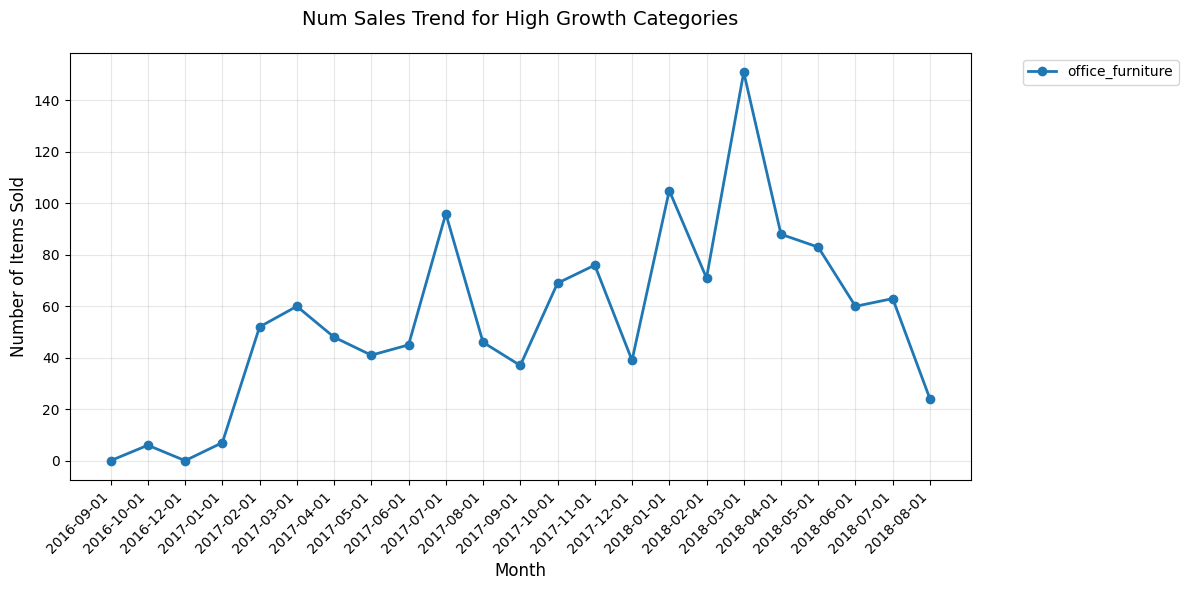

In [33]:
high_growth_categories = ["office_furniture"]

plot_category_sales_trend(
    categories=high_growth_categories,
    df_merged=df_orders_item_products_merged,
    start_date="2016-09",
    end_date="2018-08",
    title="Num Sales Trend for High Growth Categories",
    agg_type="revs",
)